Model Definition

In [13]:
# import necessary packages
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tvt

import matplotlib.pyplot as plt
from utilities import *

from matplotlib.colors import LinearSegmentedColormap

from functools import reduce
from functools import partial

#   # Create a custom colormap that is inverted
cmap = plt.cm.viridis  # Choose the colormap you want to invert
cmap_inverted = LinearSegmentedColormap.from_list("inverted_viridis", cmap(np.linspace(1, 0, 256)))



from timeit import default_timer
import scipy.io
import os
import sys
from itertools import chain
import time
import pykonal


from scipy.io import loadmat
from astar.astar import  AStar
from astar.environment_simple import Environment3D


from TrainPlanningOperator3D import PlanningOperator3D, smooth_chi

In [14]:
# Function Definitions

def tic():
  return time.time()

# def toc(tstart, nm=""):
#   print('%s took %s sec.\n' % (nm,(time.time() - tstart)))

def toc(tstart):
   return (time.time() - tstart)


smooth_coefs = [5.]
smooth_coef = smooth_coefs[0]
# experiments to be replicated with different seeds
seeds = [5, 2000, 14000, 16000, 100000]
seeds = [seeds[0]]

Ntotal = 1000*5+200*5
ntrain = 1000*5
ntest = Ntotal-ntrain

batch_size = 1

epochs = 501
scheduler_step = 100
tol_early_stop = 500

modes = 8
width = 32
nlayers = 5

t1 = default_timer()

sub = 1
Sx = int(((30 - 1) / sub) + 1)
Sy = Sx
Sz = Sx

mask = np.load('./3d_dataset_30x30x30/mask.npy')
mask = torch.tensor(mask, dtype=torch.float)
dist_in = np.load('./3d_dataset_30x30x30/dist_in.npy')
dist_in = torch.tensor(dist_in[:Ntotal, :, :], dtype=torch.float)
input = smooth_chi(mask, dist_in, smooth_coef)
output = np.load('./3d_dataset_30x30x30/output.npy')
output = torch.tensor(output, dtype=torch.float)
goals = np.load('./3d_dataset_30x30x30/goals.npy')
goals = torch.tensor(goals, dtype=torch.float)



mask_test = mask[:Ntotal][-ntest:, ::sub, ::sub, ::sub][:, :Sx, :Sy, :Sz]
mask_test = mask_test.reshape(ntest, Sx, Sy, Sz, 1)

chi_test = input[:Ntotal][-ntest:, ::sub, ::sub, ::sub][:, :Sx, :Sy, :Sz]
chi_test = chi_test.reshape(ntest, Sx, Sy, Sz,1)

y_test = output[:Ntotal][-ntest:, ::sub, ::sub, ::sub][:, :Sx, :Sy, :Sz]
y_test = y_test.reshape(ntest, Sx, Sy, Sz, 1)

goals_test = goals[-ntest:]
goals_test = goals_test.reshape(ntest, 3, 1)

test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(mask_test, chi_test, y_test, goals_test),
                                          batch_size=batch_size,
                                          shuffle=False)

Loading the trained Model

In [15]:
# Load the trained model
model = PlanningOperator3D(modes, modes, modes, width, nlayers)
model.load_state_dict(torch.load("planningoperator_3d_30x30x30_symmetric_norm/n5000_lr5.000000e-03_gamma5.000000e-01_wd3.000000e-06_seed5/model_depth4.ckpt"))
# model.load_state_dict(torch.load("planningoperator_3d_20x20x20_symmetric_norm/n10000_lr5.000000e-03_gamma5.000000e-01_wd3.000000e-06_seed5/model_depth4.ckpt"))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

PlanningOperator3D(
  (fc0): Linear(in_features=3, out_features=32, bias=True)
  (conv0): SpectralConv3d()
  (w0): Conv3d(32, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (conv1): SpectralConv3d()
  (w1): Conv3d(32, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (conv2): SpectralConv3d()
  (w2): Conv3d(32, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (conv3): SpectralConv3d()
  (w3): Conv3d(32, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (conv4): SpectralConv3d()
  (w4): Conv3d(32, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (fc1): DeepNormMetric(
    (Us): ModuleList(
      (0-1): 2 x Linear(in_features=32, out_features=128, bias=False)
    )
    (Ws): ModuleList(
      (0): ConstrainedLinear(in_features=128, out_features=128, bias=False)
    )
    (activation): MaxReLUPairwiseActivation(
      (avg_pool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
    (output_activation): ConcaveActivation()
    (reduce_metric): ReduceMetric()
  )
)

Plot predicted and ground truth

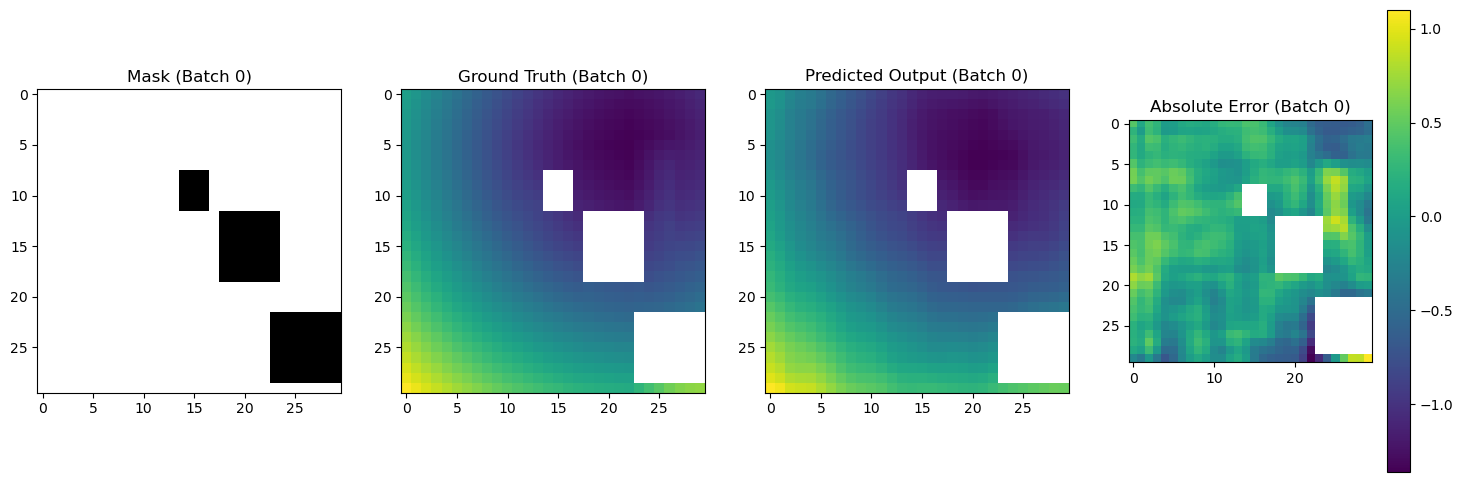

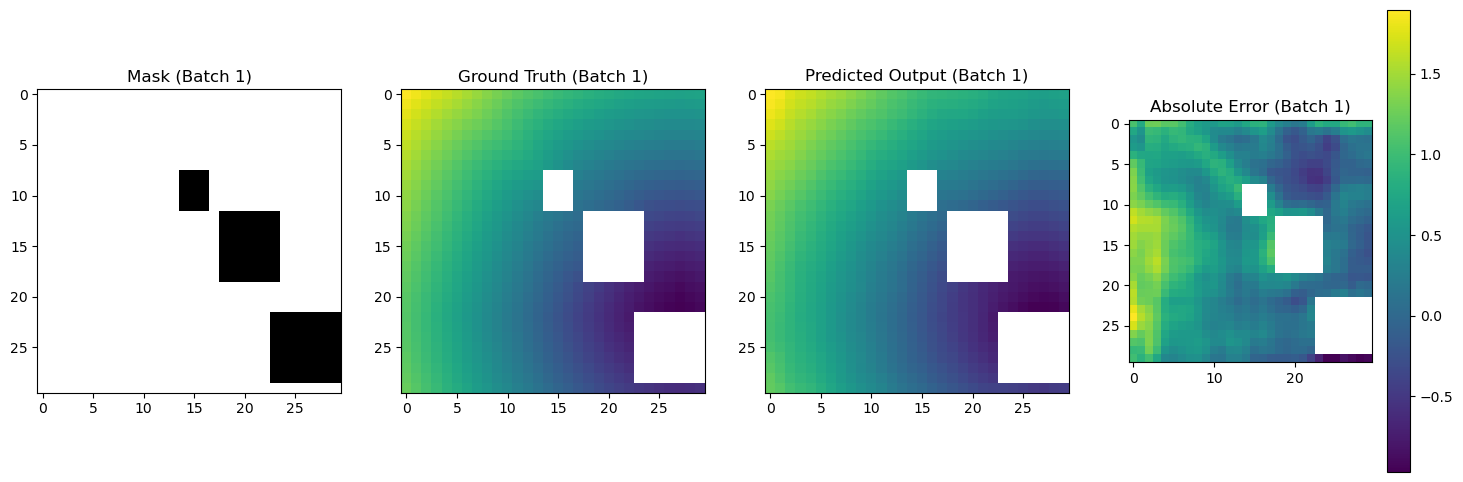

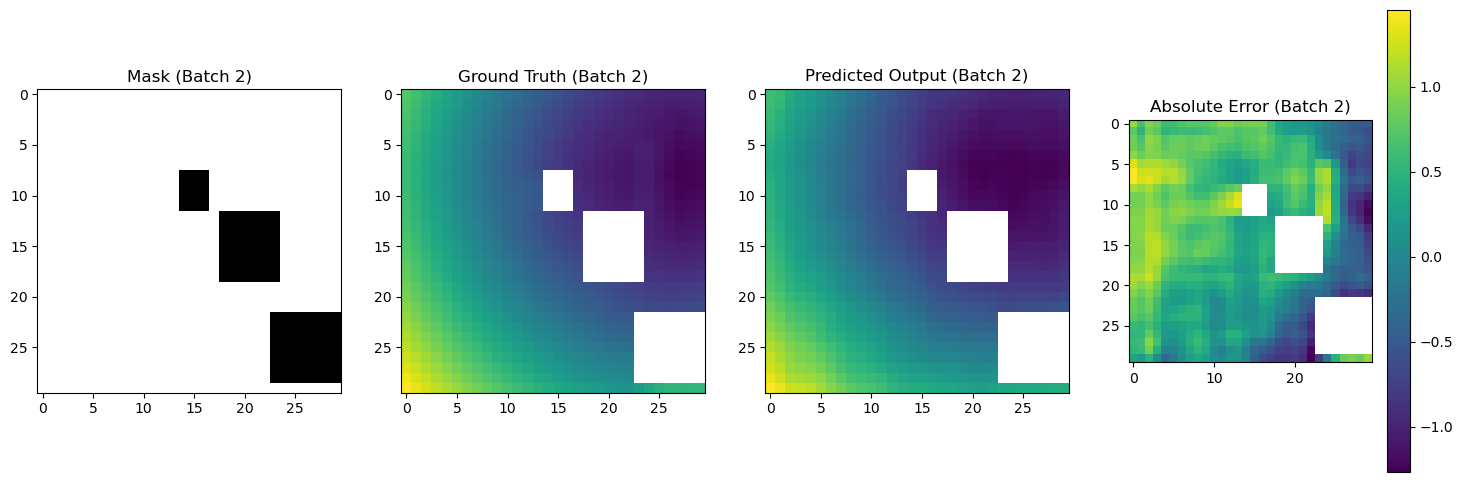

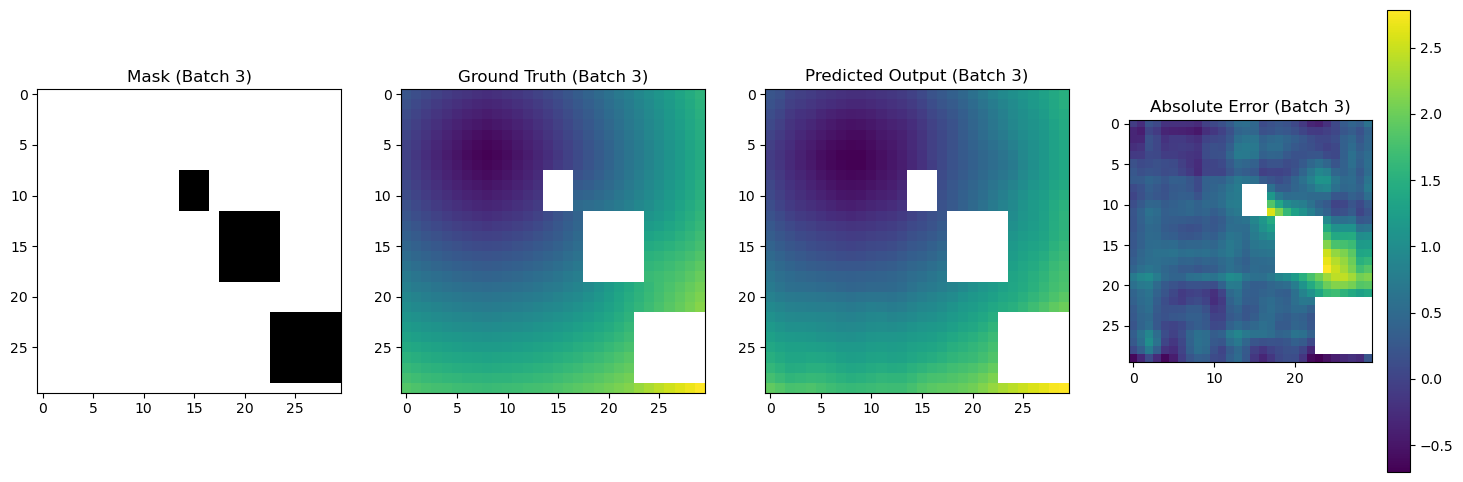

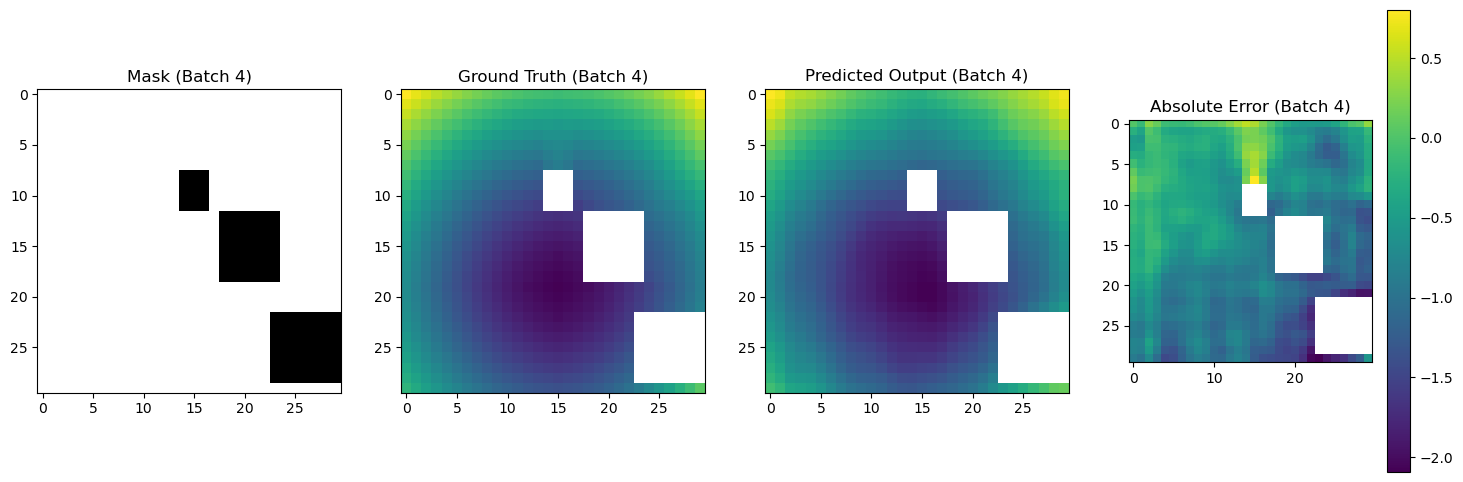

In [16]:
# Compare Ground Truth and Predicted Values for a couple of cross-sections of maps
z = 20  #Adjust Z set level

mean_error = 0
count = 0
normalization = 1/1.0  # Adjust or calculate as needed

with torch.no_grad():
    for batch_id, (mask, chi, ground_truth, gg) in enumerate(test_loader):
        mask, chi, ground_truth, gg = mask.to(device), chi.to(device), ground_truth.to(device), gg.to(device)
        predicted_output = model(chi, gg)
        predicted_output = torch.where(mask == 0, torch.tensor(float('inf')), predicted_output) 
        ground_truth = torch.where(mask == 0, torch.tensor(float('inf')), ground_truth)
        absolute_error = (ground_truth - predicted_output * normalization)
        if batch_id == 5:
            break

        # Plot results for the current batch
        plt.figure(figsize=(18, 6))
        
        titles = ['Mask', 'Ground Truth', 'Predicted Output', 'Absolute Error']
        images = [
            mask[0, :, :, z,0].cpu().numpy(),
            ground_truth[0, :, :,z, 0].cpu().numpy(),
            predicted_output[0, :, :,z, 0].cpu().numpy(),
            absolute_error[0, :, :,z, 0].cpu().numpy()
        ]
        for i in range(4):
            plt.subplot(1, 4, i+1)
            plt.imshow(images[i], cmap='viridis' if i > 0 else 'gray')
            plt.title(f'{titles[i]} (Batch {batch_id})')
            if i == 3:
                plt.colorbar()
        plt.show()

In [17]:
#Gradient Descent Function

# Primary movements in 3D: forward, backward, left, right, up, down
primary_moves = [
    [-1., 0., 0.],  # left
    [1., 0., 0.],   # right
    [0., 1., 0.],   # forward
    [0., -1., 0.],  # backward
    [0., 0., 1.],   # up
    [0., 0., -1.]   # down
]

# Diagonal movements in 3D
diagonal_moves = [
    [-1., 1., 0.],  # left-forward
    [-1., -1., 0.], # left-backward
    [1., 1., 0.],   # right-forward
    [1., -1., 0.],  # right-backward
    [-1., 0., 1.],  # left-up
    [-1., 0., -1.], # left-down
    [1., 0., 1.],   # right-up
    [1., 0., -1.],  # right-down
    [0., 1., 1.],   # forward-up
    [0., 1., -1.],  # forward-down
    [0., -1., 1.],  # backward-up
    [0., -1., -1.], # backward-down
    [-1., 1., 1.],  # left-forward-up
    [-1., 1., -1.], # left-forward-down
    [-1., -1., 1.], # left-backward-up
    [-1., -1., -1.],# left-backward-down
    [1., 1., 1.],   # right-forward-up
    [1., 1., -1.],  # right-forward-down
    [1., -1., 1.],  # right-backward-up
    [1., -1., -1.]  # right-backward-down
]

# Combine primary and diagonal moves
action_vecs = np.asarray(primary_moves + diagonal_moves)

def perform_gradient_descent(value_function, start_point, goal_point, plotsuccess=False, plotfails=False, learning_rate=1, num_steps=1000):
    # print("Start Position:",start_point)
    # print("Goal Position:", goal_point)
    path_length = 0
    path_points = [start_point.copy().astype(float)]
    visited_points = set()
    current_point = start_point.copy().astype(float)

    for step in range(num_steps):
        best_gradient = np.inf
        best_action = None

        for action in action_vecs:
            new_point = current_point + learning_rate * action
            new_point_indices = np.round(new_point).astype(int)
            x_index, y_index, z_index = new_point_indices

            if (0 <= x_index < value_function.shape[0] and 
                0 <= y_index < value_function.shape[1] and 
                0 <= z_index < value_function.shape[2] and 
                (x_index, y_index, z_index) not in visited_points):
                gradient = value_function[x_index, y_index, z_index]
                if gradient < best_gradient:
                    best_gradient = gradient
                    best_action = action

        if best_gradient > 100:
            if plotfails:
                print("Failed Path:")
                plot_path(value_function, path_points)
            return False, 0  

        if best_action is not None:
            current_point += learning_rate * best_action
            path_length += np.linalg.norm(learning_rate * best_action)
            path_points.append(current_point.copy())
            visited_points.add(tuple(np.round(current_point).astype(int)))
            if np.array_equal(np.round(current_point).astype(int), np.round(goal_point).astype(int)):
                if plotsuccess:
                    print("Successful Path:")
                    plot_path(value_function, path_points)
                return True, path_length  # Success
        else:
            if plotfails:
                print("Failed Path:")
                plot_path(value_function, path_points)
            return False, 0  # No valid action found
    if plotfails:
        print("Failed Path:")
        plot_path(value_function, path_points)
    return False, 0  

def plot_path(value_function, path_points):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    path_points = np.array(path_points)

    # Identify and plot points where value function is infinite
    inf_indices = np.where(np.isinf(value_function))
    ax.scatter(inf_indices[0], inf_indices[1], inf_indices[2], c='k', marker='o', label='Obstacles')

    # Plot the path
    ax.plot(path_points[:, 0], path_points[:, 1], path_points[:, 2], 'ro-', label='Path')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.show()



In [18]:
# Compare against classical Planners

nosuceesscount = 0
notime = 0
nopath = 0

astarsuccesscount = 0
astartime = 0
astarpath = 0

fmmsuccesscount = 0
fmmtime = 0
fmmpath = 0

with torch.no_grad():
    for batch_id, (mask, chi, ground_truth, gg) in enumerate(test_loader):
        mask, chi, ground_truth, gg = mask.to(device)[0,:,:,:,0].reshape(1,30,30,30,1), chi.to(device)[0,:,:,:,0].reshape(1,30,30,30,1), ground_truth.to(device)[0,:,:,:,0].reshape(1,30,30,30,1), gg.to(device)[0,:,0].reshape(1,3,1)
        goal_point = gg[0,:,0].cpu().numpy()
        start_point = np.array([0,0,0])
        
        # Neural Operator Planning
        t1 = tic()
        predicted_output = model(chi, gg)
        predicted_output = torch.where(mask == 0, torch.tensor(float('inf')), predicted_output)
        value_function = predicted_output[0, :, :, :, 0].cpu().detach().numpy()
        success, pathlength = perform_gradient_descent(value_function,start_point,goal_point)
        dt = toc(t1)

        if(success):
            nosuceesscount+=1
            notime+=dt
            nopath+=pathlength

        cmap =  1-mask.squeeze().cpu().detach().numpy()
        goal_coord = goal_point
        start_coord = start_point
        env = Environment3D(goal_coord,cmap)

        # A* Planning
        t1 = tic()
        path_cost, path, action_idx = AStar.plan(start_coord, env)
        dt = toc(t1)

        if(path_cost < np.inf):
            astarsuccesscount+=1
            astartime+=dt
            astarpath+=path_cost

        # FMM Planning
        t1 = tic()
        solver = pykonal.EikonalSolver(coord_sys = "Cartesian")
        velocity_matrix  = 1 - cmap
        solver.velocity.min_coords = 0, 0, 0
        solver.velocity.node_intervals = 1, 1, 1
        solver.velocity.npts = Sx, Sy, Sz
        solver.velocity.values = velocity_matrix.reshape(Sx, Sy, Sz)
        src_idx = goal_point[0].astype(int), goal_point[1].astype(int), goal_point[2].astype(int)
        solver.traveltime.values[src_idx] = 0
        solver.unknown[src_idx] = False
        solver.trial.push(*src_idx)
        solver.solve()
        success, pathlength = perform_gradient_descent(solver.traveltime.values,start_point,goal_point)
        dt = toc(t1)

        if(success):
            fmmsuccesscount+=1
            fmmtime+=dt
            fmmpath+=pathlength



      

print("A* success rate",(astarsuccesscount/(batch_id+1)),"A* avg time",(astartime/astarsuccesscount),"A* pathcost",(astarpath/astarsuccesscount))
print("FMM success rate",(fmmsuccesscount/(batch_id+1)), "FMM avg time",(fmmtime/fmmsuccesscount),    "FMM pathcost",(fmmpath/fmmsuccesscount))
print("NO success rate",(nosuceesscount/(batch_id+1)),   "NO avg time",(notime/nosuceesscount),      "NO pathcost",(nopath/nosuceesscount))


A* success rate 1.0 A* avg time 0.06422888088226318 A* pathcost 30.54816231672353
FMM success rate 1.0 FMM avg time 0.013936846494674682 FMM pathcost 30.620667053578497
NO success rate 1.0 NO avg time 0.019867661714553835 NO pathcost 31.969246758162594
